In [1]:
import torch.nn as nn
import random
import torch
import torchvision
import numpy as np
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, Dataset
from torchsummary import summary
%matplotlib inline

In [2]:
from skimage.io import imread

In [3]:
#data_dir = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Train"
#test_data_dir = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Test"
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))])

#dataset = ImageFolder(data_dir,transform = normalize_transform)
#test_dataset = ImageFolder(test_data_dir,transform= normalize_transform)

In [4]:
from skimage.io import imread

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))
])

#train2 = ImageFolder(data_dir,transform = transforms)

In [6]:
root = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Project\Train"

In [7]:
dataset = ImageFolder(root,transform = transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
dataset2 = ImageFolder(root,transform = transforms)
train_size2 = int(0.8 * len(dataset2))
test_size2 = len(dataset) - train_size
train_dataset2, test_dataset2 = random_split(dataset, [train_size2, test_size2])

In [9]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
#train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size)
#test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=batch_size)

(-0.5, 755.5, 151.5, -0.5)

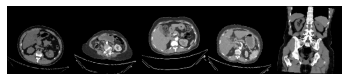

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:5], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

In [12]:
classes = []
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data 
    classes.extend(y.tolist())

KeyboardInterrupt: 

In [11]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [12]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(resnet50, self.).__init__()
        self.model = resnet50(weights=None)
        self.classifier_layer = nn.Sequential(
            nn.Linear(1, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256 , 128),
            nn.Linear(128 , 2))
  
    def forward(self, x):
        batch_size ,_,_,_ = x.shape #taking out batch_size from input image
        x = self.model.extract_features(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x,1).reshape(batch_size,-1) # then reshaping the batch_size
        x = self.classifier_layer(x)
        return x

SyntaxError: invalid syntax (626259141.py, line 3)

In [12]:
from torchvision.models import resnet50

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = CNN().to(device)
model = resnet50(weights=None)
modules = list(model.children())[:-2]      # delete the last fc layer.
model.fc = nn.Linear(2048 , 2)
"""model = nn.Sequential(
            *modules,
            nn.Linear(2048 , 1000)
            )
for param in model.parameters():
    param.requires_grad = False"""

'model = nn.Sequential(\n            *modules,\n            nn.Linear(2048 , 1000)\n            )\nfor param in model.parameters():\n    param.requires_grad = False'

In [14]:
model = model.to(device)

In [15]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,096
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,384
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:

#Defining the model hyper parameters
num_epochs = 50
learning_rate = 0.00001
weight_decay = 0.01
weights = torch.Tensor([0.4, 0.6])
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss(size_average=True)
criterion.to(device)
#criterion = torch.nn.BCELoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

d:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [36]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#print(labels.shape)
outputs = model(images)
labels = F.one_hot(labels, num_classes=2)
#print(torch.sigmoid(outputs))
loss = criterion(F.sigmoid(outputs), labels.float())
print(loss)
#loss = criterion(outputs, labels)

d:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(7.3331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [30]:
labels = F.one_hot(labels, num_classes=2)
print(labels.shape)


torch.Size([32, 2])


In [18]:
 
#Training process begins for Normal Data
def trainmodel(model, num_epochs, loader, criterion, optimizer):
    train_loss_list = []
    train_acc = 0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
        train_loss = 0
      
        #Iterating over the training dataset in batches
        model.train()
        for i, (images, labels) in enumerate(loader):
            #if i > 0 and i%5 == 0:
            #images, labels = mixup(images, labels, 0.2, 2)

          
            #Extracting images and target labels for the batch being iterated
            images = images.to(device)
            labels = labels.to(device)
  
            #Calculating the model output and the cross entropy loss
            outputs = model(images)
            loss = criterion(nn.Sigmoid(outputs), labels.unsqueeze(1))
  
            #Updating weights according to calculated loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            _, y_pred = torch.max(outputs.data, 1)

            #Comparing predicted and true labels
            train_acc += (y_pred == labels).sum().item()
      
        print(f"Train set accuracy = {100 * train_acc / len(loader)} %")
      
        #Printing loss for each epoch
        train_loss_list.append(train_loss/len(loader))
        print(f"Training loss = {train_loss_list[-1]}")   
      
    #Plotting loss for all epochs
    plt.plot(range(1,num_epochs+1), train_loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")
    return


In [24]:
def trainmodel(model, num_epochs, loader, criterion, optimizer):
    correct = 0
    total = 0
    train_loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)
            y_true = labels.to(device)
  
            outputs = model(images)
            labels = F.one_hot(labels, num_classes=2)
            loss = criterion(F.sigmoid(outputs), labels.float())
  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            _, predicted = torch.max(outputs.data, 1)
            total += y_true.size(0)
            correct += (predicted == y_true).sum().item()

        #Accuracy
        train_loss_list.append(train_loss/len(loader))
        accuracy = 100 * correct / total
        print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, train_loss_list[-1], accuracy))
    plt.plot(range(1,num_epochs), train_loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")
    return

In [22]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [23]:
trainmodel(model, num_epochs, train_loader, criterion, optimizer)

d:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/50, Loss: 0.560, Accuracy: 74.312
Epoch 2/50, Loss: 0.513, Accuracy: 74.420
Epoch 3/50, Loss: 0.420, Accuracy: 76.157
Epoch 4/50, Loss: 0.362, Accuracy: 77.832
Epoch 5/50, Loss: 0.339, Accuracy: 79.090
Epoch 6/50, Loss: 0.320, Accuracy: 80.074
Epoch 7/50, Loss: 0.307, Accuracy: 80.861
Epoch 8/50, Loss: 0.299, Accuracy: 81.520
Epoch 9/50, Loss: 0.284, Accuracy: 82.087
Epoch 10/50, Loss: 0.284, Accuracy: 82.567
Epoch 11/50, Loss: 0.270, Accuracy: 82.996
Epoch 12/50, Loss: 0.268, Accuracy: 83.355
Epoch 13/50, Loss: 0.262, Accuracy: 83.708
Epoch 14/50, Loss: 0.252, Accuracy: 84.034
Epoch 15/50, Loss: 0.248, Accuracy: 84.314
Epoch 16/50, Loss: 0.241, Accuracy: 84.575
Epoch 17/50, Loss: 0.238, Accuracy: 84.844
Epoch 18/50, Loss: 0.231, Accuracy: 85.057
Epoch 19/50, Loss: 0.230, Accuracy: 85.270
Epoch 20/50, Loss: 0.224, Accuracy: 85.476
Epoch 21/50, Loss: 0.215, Accuracy: 85.662
Epoch 22/50, Loss: 0.207, Accuracy: 85.873
Epoch 23/50, Loss: 0.213, Accuracy: 86.019
Epoch 24/50, Loss: 0

In [25]:
def testmodel(model, loader):
    test_acc=0
    model.eval()
  
    with torch.no_grad():
        #Iterating over the training dataset in batches
        for i, (images, labels) in enumerate(loader):
          
            images = images.to(device)
            y_true = labels.to(device)
          
            #Calculating outputs for the batch being iterated
            outputs = model(images)
          
            #Calculated prediction labels from models
            _, y_pred = torch.max(outputs.data, 1)

            #Comparing predicted and true labels
            test_acc += (y_pred == y_true).sum().item()
      
        print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

In [26]:
testmodel(model, test_loader)

Test set accuracy = 91.70251997541487 %


In [27]:
torch.save(model.state_dict(), 'resnet50.pth')

In [28]:
fname = 'D:\\Git\\Research Paper\\Research_Project\\projectCNN.pth'
loaded_dict = torch.load(fname)
model.load_state_dict(loaded_dict)

<All keys matched successfully>

In [21]:
images = images.to(device)
y_true = labels.to(device)
outputs = model(images)
print(outputs)

NameError: name 'images' is not defined

In [29]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

In [30]:
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class : Stone


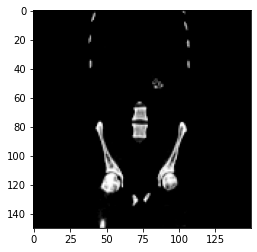

In [31]:
from PIL import Image

#open image file
img_path = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Test\Stone\Stone- (1100).jpg"
img = Image.open(img_path)

#convert image to tensor
img = normalize_transform(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

Computer Vision

In [32]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [36]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [33]:
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)


edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)


cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)


(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

In [37]:
for c in cnts:
    	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue
	# compute the rotated bounding box of the contour
	orig = image.copy()
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")
	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
	# loop over the original points and draw them
	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

In [38]:
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)
	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)
	# draw the midpoints on the image
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
	# draw lines between the midpoints
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [39]:
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / 3

In [1]:
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric
	# draw the object sizes on the image
	cv2.putText(orig, "{:.1f}in".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	cv2.putText(orig, "{:.1f}in".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	# show the output image
	cv2.imshow("Image", orig)
	cv2.waitKey(0)

NameError: name 'dA' is not defined